## Music Style Detector : CNN with Mel Spectogram

This notebook contains experimentation to create a music style detector by building a CNN model with Mel spectogram as input. The model is trained on a custom part of the FMA dataset and evaluated on the GTZAN dataset.

### 1. Imports and setup

In [1]:
import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
import torchaudio
from torch.utils.data import DataLoader, Dataset, random_split

from sklearn.model_selection import train_test_split
from datetime import datetime
import wandb
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
import pandas as pd
import random
import os
import json

MODEL_DIR = os.path.abspath(os.path.join(os.getcwd(), '../..', 'models', 'genre_detector'))
DATA_DIR = os.path.join(MODEL_DIR, 'data')

### 2. Data pre-processing

In [2]:
class AudioUtil():
    """
    Utility class for audio processing.
    """
    @staticmethod
    def open(audio_file: str):
        """
        Load an audio file. Return the signal as a tensor and the sample rate.
        :param audio_file : Path to the audio file.
        :type audio_file : str
        :return: signal as a tensor and the sample rate
        :rtype: Tuple[torch.Tensor, int]
        """
        signal, sample_rate = torchaudio.load(audio_file)
        return (signal, sample_rate)
    
    @staticmethod
    def rechannel(audio, new_channel):
        """
        Convert a given audio to the specified number of channels.
        :param audio: the audio, composed of the signal and the sample rate
        :type audio: Tuple[torch.Tensor, int]
        :param new_channel: the target number of channels
        :type new_channel: int
        :return: the audio with the target number of channels
        :rtype: Tuple[torch.Tensor, int]
        """
        signal, sample_rate = audio

        if (signal.shape[0] == new_channel):
            # nothing to do as the signal already has the target number of channels
            return audio
        if (new_channel == 1):
            # convert to mono by selecting only the first channel
            signal = signal[:1, :]
        else:
            # convert to stereo by duplicating the first channel
            signal = torch.cat([signal, signal])
        return (signal, sample_rate)
    
    @staticmethod
    def resample(audio, new_sample_rate):
        """
        Change the sample rate of the audio signal.
        :param audio: the audio, composed of the signal and the sample rate
        :type audio: Tuple[torch.Tensor, int]
        :param new_sample_rate: the target sample rate
        :type new_sample_rate: int
        :return: the audio with the target sample rate
        :rtype: Tuple[torch.Tensor, int]
        """
        signal, sample_rate = audio
        if (sample_rate == new_sample_rate):
            # nothing to do
            return audio
        resample = torchaudio.transforms.Resample(sample_rate, new_sample_rate)
        signal = resample(signal)
        return (signal, new_sample_rate)
    
    @staticmethod
    def pad_truncate(audio, length):
        """
        Pad or truncate an audio signal to a fixed length (in ms).
        :param audio: the audio, composed of the signal and the sample rate
        :type audio: Tuple[torch.Tensor, int]
        :param length: the target length in ms
        :type length: int
        :return: the audio with the target length
        :rtype: Tuple[torch.Tensor, int]
        """
        signal, sample_rate = audio
        max_length = sample_rate//1000 * length

        if (signal.shape[1] > max_length):
            signal = signal[:, :max_length]
        elif (signal.shape[1] < max_length):
            padding = max_length - signal.shape[1]
            signal = F.pad(signal, (0, padding))
        return (signal, sample_rate)
    
    @staticmethod
    def mel_spectrogram(audio, n_mels=64, n_fft=1024, hop_length=None):
        """
        Create the mel spectogram for the given audio signal.
        :param audio: the audio, composed of the signal and the sample rate
        :type audio: Tuple[torch.Tensor, int]
        :param n_mels: the number of mel filterbanks
        :type n_mels: int
        :param n_fft: the size of the FFT
        :type n_fft: int
        :param hop_length: the length of hop between STFT windows
        :type hop_length: int
        :return: the mel spectogram
        :rtype: torch.Tensor
        """
        signal, sample_rate = audio
        
        mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels
        )(signal)

        # convert to decibels
        mel_spectrogram = torchaudio.transforms.AmplitudeToDB()(mel_spectrogram)

        return mel_spectrogram

### 3. Training data loading

In [3]:
FMA_DIR = os.path.join(DATA_DIR, 'FMA')
GTZAN_DIR = os.path.join(DATA_DIR, 'GTZAN')
fma_df = pd.read_csv(os.path.join(FMA_DIR, 'fma_reduced_genres.csv'))
gtzan_df = pd.read_csv(os.path.join(GTZAN_DIR, 'gtzan_genres.csv'))
fma_df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\benja\\Projects\\MLodImage\\code\\models\\style_detector\\data\\FMA\\fma_reduced_genres.csv'

In [9]:
# create a map of the genre_id to genre_label
id_to_label = fma_df.set_index('genre_id')['genre_label'].to_dict()
print(id_to_label)

{1: 'Classical', 4: 'Electronic', 5: 'Hip-Hop', 8: 'Pop', 10: 'Rock', 6: 'Jazz', 9: 'Reggae', 3: 'Disco', 0: 'Blues', 2: 'Country', 7: 'Metal'}


In [10]:
AUDIO_DURATION = 3000 # equals 30 seconds
SAMPLE_RATE = 44100
N_CHANNELS = 1
BATCH_SIZE = 32
NB_CLASSES = fma_df['genre_id'].nunique()
print(NB_CLASSES)

11


In [11]:
class GenreDataset(Dataset):
    """
    Dataset for the FMA dataset.
    """
    def __init__(self, df, audio_dir):
        """
        Constructor.
        :param df: the dataframe containing the audio files ids and their genre label
        :type df: pandas.DataFrame
        :param audio_dir: the directory containing the audio files
        :type audio_dir: str
        """
        self.fma_df = df
        self.audio_dir = audio_dir
        
    def __len__(self):
        """
        Get the length of the dataset.
        :return: the length of the dataset
        :rtype: int
        """
        return len(self.fma_df)
    
    def __getitem__(self, idx):
        """
        Get the idx-th sample of the dataset.
        :param idx: the index of the sample
        :type idx: int
        :return: the idx-th sample of the dataset and its genre label
        :rtype: Tuple[torch.Tensor, int]
        """ 
        audio_file_path = os.path.join(self.audio_dir, str(self.fma_df.iloc[idx]['filename']))
        # get the genre class id
        genre_id = self.fma_df.iloc[idx]['genre_id']

        # load the audio file and apply the preprocessing
        audio = AudioUtil.open(audio_file_path)
        audio = AudioUtil.rechannel(audio, N_CHANNELS)
        audio = AudioUtil.resample(audio, SAMPLE_RATE)
        audio = AudioUtil.pad_truncate(audio, AUDIO_DURATION)
        mel_spectrogram = AudioUtil.mel_spectrogram(audio)

        return (mel_spectrogram, genre_id)

64 258


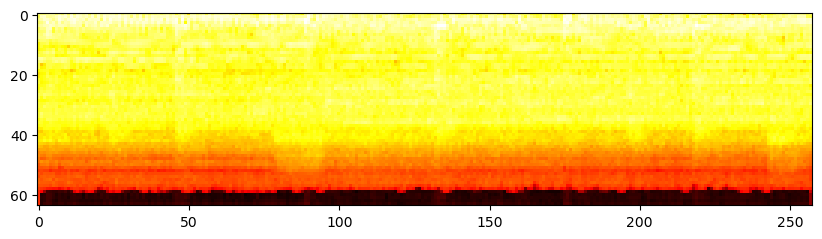

In [12]:
full_dataset = GenreDataset(fma_df, os.path.join(FMA_DIR, 'fma_reduced'))

# random split
nb_samples = len(full_dataset)
nb_train_samples = int(nb_samples * 0.8)
nb_val_samples = nb_samples - nb_train_samples
train_dataset, val_dataset = random_split(full_dataset, [nb_train_samples, nb_val_samples])

# create the data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

# get first batch
batch = next(iter(train_loader))

mel_spectrogram = batch[0][0]
# print shape of the mel spectrogram
INPUT_HEIGHT = mel_spectrogram.shape[1]
INPUT_WIDTH = mel_spectrogram.shape[2]
print(INPUT_HEIGHT, INPUT_WIDTH)
# plot the two channels as image
plt.figure(figsize=(10, 4))
plt.imshow(mel_spectrogram[0].numpy(), cmap='hot', interpolation='nearest')
plt.show()

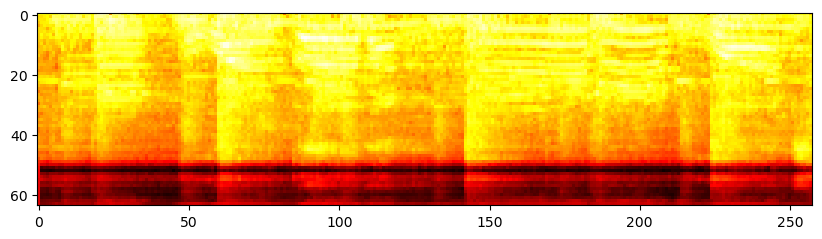

In [13]:
gtzan_dataset = GenreDataset(gtzan_df, os.path.join(GTZAN_DIR, 'genres_original_all'))

test_loader = DataLoader(gtzan_dataset, batch_size=BATCH_SIZE, shuffle=False)

# get first batch
batch = next(iter(test_loader))

mel_spectrogram = batch[0][0]
plt.figure(figsize=(10, 4))
plt.imshow(mel_spectrogram[0].numpy(), cmap='hot', interpolation='nearest')
plt.show()

### 4. Model creation

In [14]:
class AudioCNN(nn.Module):
    """
    Simple CNN for audio classification.
    """
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * INPUT_HEIGHT//2 * INPUT_WIDTH//2, 256)
        self.fc2 = nn.Linear(256, NB_CLASSES)

    def forward(self, x):
        x = (F.relu(self.conv1(x)))
        x = (F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x


In [15]:
# Create the model and put it on the GPU if available
model = AudioCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# Check that it is on Cuda
next(model.parameters()).device

device(type='cuda', index=0)

### 5. Model training

In [11]:
def validate(model, val_loader, criterion):
    model.eval()

    with torch.no_grad():
        val_loss = 0.0
        correct, total = 0, 0
        y_true, y_pred = [], []
        for batch_idx, (inputs, labels) in enumerate(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

        return val_loss / len(val_loader), correct / total, y_true, y_pred

In [12]:
date_time = datetime.now().strftime("%y%m%d%H%M")
wandb.init(project="audio-classification", name="cnn-{}".format(date_time), notes="baseline model", config={
    "learning_rate": 0.001,
    "epochs": 30,
    "batch_size": BATCH_SIZE,
    "loss_function": "cross-entropy",
    "architecture": "CNN",
    "dataset": "FMA",
    "optimizer": "Adam"
    })

config = wandb.config


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: benjamin-pasquier. Use `wandb login --relogin` to force relogin


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

In [14]:
for epoch in range(config.epochs):
    model.train() # put model to training mode
    correct, total = 0, 0
    training_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        outputs = model(inputs)
        train_loss = criterion(outputs, labels)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        training_loss += train_loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # nb of samples in batch
        correct += (predicted == labels).sum().item()

    val_loss, val_accuracy, y_true, y_pred = validate(model, val_loader, criterion)

    metrics = {'epoch': epoch, 'train_loss': training_loss / len(train_loader),
                   'train_accuracy': correct / total, 'val_loss': val_loss,
                   'val_accuracy': val_accuracy}
    
    wandb.log(metrics)
    
    if epoch + 1 == config.epochs:
        wandb.log({'confusion_matrix': wandb.plot.confusion_matrix(probs=None, y_true=y_true,
                                                                    preds=y_pred,
                                                                    class_names=list(id_to_label.values()))})
        wandb.save('cnn-{}.h5'.format(date_time))
        
print('Finished Training')
wandb.finish()


Finished Training


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_accuracy,▁▂▃▅▇█████████████████████████
train_loss,█▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▆▆█▆▅▃▃▄▁▂▂▃▄▃▅▅▅▅▅▅▅▅▅▅▅▅▄▅▅▅
val_loss,▁▁▁▂▃▄▅▅▆▅▆▆▇▇▆▆▇▇▇▇▇▇▇▇▇▇▇███
epoch,29
train_accuracy,0.99886
train_loss,0.00106
val_accuracy,0.39756
val_loss,5.98646


### 5. Model evaluation

In [15]:
# on validation set
correct_predictions = 0
total_predictions = 0
with torch.no_grad():
    for data in val_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

print('Accuracy of the network on the {} validation samples: {}%'.format(
    total_predictions, 100 * correct_predictions / total_predictions))

Accuracy of the network on the 1313 validation samples: 39.75628332063975%


In [16]:
# on test set
correct_predictions = 0
total_predictions = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

print('Accuracy of the network on the {} test samples: {}%'.format(
    total_predictions, 100 * correct_predictions / total_predictions))

Accuracy of the network on the 999 test samples: 21.32132132132132%


In [18]:
# save the model
torch.save(model, os.path.join(MODEL_DIR, 'cnn-{}.h5'.format(date_time)))

### 6. Test single inference

In [16]:
# load the model
loaded_model = torch.load(os.path.join(MODEL_DIR, 'cnn-2305031712.h5'))
loaded_model.eval()
loaded_model = loaded_model.to(device)

# load 'blues.00001.wav' and predict its genre
audio = AudioUtil.open('000002.mp3')
audio = AudioUtil.rechannel(audio, N_CHANNELS)
audio = AudioUtil.resample(audio, SAMPLE_RATE)
audio = AudioUtil.pad_truncate(audio, AUDIO_DURATION)
mel_spectrogram = AudioUtil.mel_spectrogram(audio)

# inference
inputs = mel_spectrogram.unsqueeze(0)
inputs = inputs.to(device)
outputs = loaded_model(inputs)
_, predicted = torch.max(outputs.data, 1)

outputs_list = outputs.data.tolist()[0]
# create a dict of genre: probability
probs = {id_to_label[i]: round(outputs_list[i], 4) for i in range(len(id_to_label))}
print(probs)
print(outputs_list)
print('Predicted: {}'.format(id_to_label[predicted.item()]))

{'Blues': 0.7841, 'Classical': -0.6878, 'Country': -0.9313, 'Disco': -1.9478, 'Electronic': 3.3723, 'Hip-Hop': 6.4339, 'Jazz': 1.4514, 'Metal': -2.4342, 'Pop': 5.0932, 'Reggae': 4.0144, 'Rock': -1.2118}
[0.7841392159461975, -0.6877682209014893, -0.9312679171562195, -1.9478323459625244, 3.3722758293151855, 6.433861255645752, 1.4514498710632324, -2.4342281818389893, 5.093160629272461, 4.014369487762451, -1.2118483781814575]
Predicted: Hip-Hop


In [6]:
# save dictionary mapping id to label as json file
with open(os.path.join(MODEL_DIR, 'id_to_label.json'), 'w') as fp:
    json.dump(id_to_label, fp)